In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

from tqdm import tqdm
import pickle
import time

import scipy.fftpack as fft

from swimAD2 import swimAD2 as ad2
import dwfconstants as dwfc

import threading

########## Begin function defining ##########

def find_times(ch1,ch2):
# Test by first bringing backwards. If fails, test forwards. 
    ''' **Warning**
    Ch1s seem to have an offset. Ch2s will thus have a better match.
    '''
    
    backward,forward = [],[]
    for i in range(1,150):
        score = abs((ch1[i:]-ch2[:-i])/(ch1[i:]+ch2[:-i]))
        backward.append(np.mean(score))

        score = abs((ch1[:-i]-ch2[i:])/(ch1[:-i]+ch2[i:]))
        forward.append(np.mean(score))

    score_back = np.min(backward)
    score_forw = np.min(forward)

    if score_back > score_forw:
        i = np.argmin(forward)
        direction = "f"
    else: 
        i = np.argmin(backward) 
        direction = "b"
    return i, direction

def sync_series(t0,ch1,ch2,ch3,ref):
    '''
    "ref" is the duplicate channel used for reference
    '''
    i,direction = find_times(ch2,ref)
    if direction=="b":
        return t0[:-i],ch1[:-i],ch2[:-i],ch3[i:]
    else: 
        return t0[i:],ch1[i:],ch2[i:],ch3[:-i]

def sampling(time):
    # Priority on oscilloscope detection rata
    size = 8192
    rate = size/time
    return rate

########## End function defining ##########

ad2.disconnect()            
zoroku = ad2.connect(0)
alice = ad2.connect(1)

# Syncronisation test

We test with an RC curve whether the above works indeed. 

In [2]:
freq = np.linspace(1e-2,5e3,1000)
amp = np.linspace(5e-2,2,1000)

# freq = np.linspace(200,400,2)
# amp = np.linspace(1,2,1)

data = {}
for F in amp:
    data[F] = {}
    for f in freq:
        data[F][f] = []

def measure(device):
    for F in tqdm(amp,leave=False):
        for f in tqdm(freq,leave=False):
            rate = sampling(50/f)   
            ad2.config_oscilloscope(zoroku
                                    , range0=20, range1=20
                                    , sample_rate=rate)
            ad2.config_oscilloscope(alice
                                    , range0=20, range1=20
                                    , sample_rate=rate)

            ad2.config_wavegen(device, frequency=f, amplitude=F, signal_shape=dwfc.funcSine)
            ad2.start_wavegen(zoroku, channel=0)
            
            time.sleep(0.1)
            t0, ch1, ch2 = ad2.measure_oscilloscope(device)

            ad2.stop_wavegen(zoroku, channel=0)
            ad2.reset_wavegen(zoroku, channel=0)
            time.sleep(0.1)
            
            # First list is zoroku, second is alice.
            data[F][f].append([t0, ch1, ch2]) 

def main():
    threads = []
    for devices in [zoroku, alice]:
        thread = threading.Thread(name=devices, target=measure, args=(devices,))
        threads.append(thread)
        thread.start()
    for thread in threads:
        thread.join()

main()


  0%|          | 0/1000 [00:00<?, ?it/s]




100%|██████████| 2/2 [00:00<00:00, 102.01it/s]

8072
8171


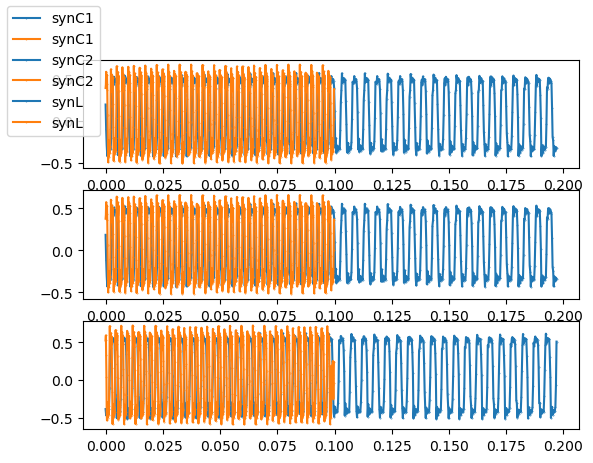

In [13]:
fig,axs = plt.subplots(3,1)
for F in amp:
    for f in tqdm(freq):
        t1,C1,C2 = data[F][f][0] # First list is zoroku (driver)
        t2,L,ref = data[F][f][1] # Second list is alice

        ts,xs,ys,zs = sync_series(t1,C1,C2,L,ref)
        print(len(ts))
        ts = ts[::10]
        xs = xs[::10]
        ys = ys[::10]
        zs = zs[::10]
        # axs[0].plot(t1,C1,marker=".",markersize=0.3,label="C1")
        # axs[1].plot(t1,C2,marker=".",markersize=0.3,label="C2")
        # axs[1].plot(t2,ref,marker=".",markersize=0.3,label="ref")
        # axs[2].plot(t2,L,marker=".",markersize=0.3,label="L")
        
        axs[0].plot(ts,xs,marker="o"
                    # ,linestyle=None
                    ,markersize=0.3,label="synC1")
        axs[1].plot(ts,ys,marker="o",linestyle=None,markersize=0.3,label="synC2")
        axs[2].plot(ts,zs,marker="o",linestyle=None,markersize=0.3,label="synL")
fig.legend(loc="upper left")
plt.show()
plt.close("all")

In [56]:
freq = np.linspace(1e-2,5e3,1001)
amp = np.linspace(8e-2,.1,9)
print(freq,amp)
print(ts,zs)

[1.00000000e-02 5.00999000e+00 1.00099800e+01 ... 4.99000002e+03
 4.99500001e+03 5.00000000e+03] [0.08   0.0825 0.085  0.0875 0.09   0.0925 0.095  0.0975 0.1   ]
[0.0000000e+00 1.2210000e-05 2.4420000e-05 ... 9.9987690e-02 9.9999900e-02
 1.0001211e-01] []


100%|██████████| 1/1 [00:00<00:00, 74.01it/s]

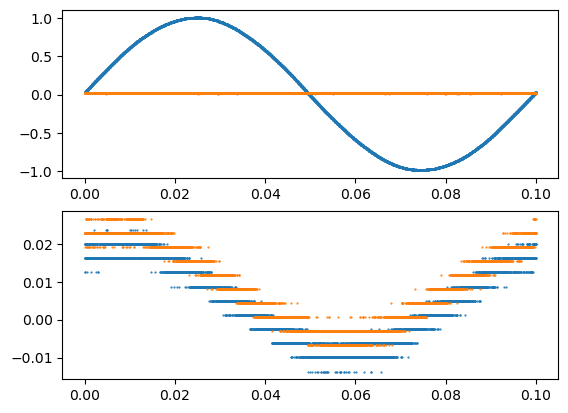

In [20]:
fig,axs = plt.subplots(2,1)
for F in amp[0:1]:
    for f in tqdm(freq[0:1]):
        t1,Ch1,Ch2 = data[F][f][0] # First list is zoroku (driver)
        t2,ch1,ch2 = data[F][f][1] # Second list is alice
        

        ts,xs,ys,_ = sync_series(t1,ch1,Ch1,ch2,Ch2)

        axs[0].scatter(t1,ch1,s=0.3); axs[0].scatter(t2,Ch1,s=0.3)
        axs[1].scatter(t1,ch2,s=0.3); axs[1].scatter(t2,Ch2,s=0.3)

plt.show()
plt.close("all")

## Old deprecated code

In [207]:
#하나는 ch1: x,ch2: y 다른 하나는 ch1: x, ch2: z에 꽂을 것 

def sampling(time):
    # Priority on oscilloscope detection rata
    size = 8192
    rate = size/time
    return rate


min_freq = 10
max_freq = 3000
num_freq = 15
rangee = 20
shape = dwfc.funcSine
amp = 0.5
freq = np.linspace(min_freq,max_freq,num_freq)

data = {}
for f in freq:
     data[round(f)] = "NA"

rate = sampling(.10)   

total_results = []

def measure(devices):
    ad2.config_oscilloscope(devices, range0=rangee, range1=rangee, sample_rate=rate)
    result = []
    for f in tqdm(list(data.keys())):
        ad2.config_wavegen(devices, frequency=f, amplitude=amp, signal_shape=shape)
        ad2.start_wavegen(devices, channel=0)
        time.sleep(0.1)
        t0, ch1, ch2 = ad2.measure_oscilloscope(devices)
        ad2.stop_wavegen(devices, channel=0)
        ad2.reset_wavegen(devices, channel=0)
        time.sleep(0.1)
        result.append([f, t0, ch1, ch2])
    total_results.append(result)

def main():
    threads = []
    for devices in [zoroku, alice]:
        thread = threading.Thread(name=str(devices), target=measure, args=(devices,))
        threads.append(thread)
        thread.start()
    for thread in threads:
        thread.join()

main()

100%|██████████| 15/15 [00:04<00:00,  3.01it/s]


In [186]:
for i in range(len(freq)):
    freq = total_results[0][i][0]; t = total_results[0][i][1]
    x,y = total_results[0][i][2], total_results[0][i][3]
    z= (total_results[1][i][3]-y)/100

    fig = plt.figure(figsize=(16, 16))
    grid = gs.GridSpec(6, 6, wspace=0.1)

    plot3D = fig.add_subplot(grid[0:2, 0:2], projection='3d')

    Xf = fft.fft(x)
    Yf = fft.fft(y)
    Zf = fft.fft(z)
    samp = 1e5
    tau = 1/samp # time interval

    fre = fft.fftfreq(len(x), tau)
    axs1 = plt.subplot(grid[0,3:5])
    axs2 = plt.subplot(grid[1,3:5])
    axs3 = plt.subplot(grid[2,3:5])

    axs1.set_xlim(left=0, right=1000, emit=True, auto=False)
    axs2.set_xlim(left=0, right=1000, emit=True, auto=False)
    axs3.set_xlim(left=0, right=1000, emit=True, auto=False)

    axs1.plot(fre[fre>=0], np.abs(Xf)[fre>=0])
    axs2.plot(fre[fre>=0], np.abs(Yf)[fre>=0])
    axs3.plot(fre[fre>=0], np.abs(Zf)[fre>=0])

    time_s = fig.add_subplot(grid[3:5, 0:])

    plot3D.scatter(x, y, z, s=0.3)

    plot3D.set_xlabel("x")
    plot3D.set_ylabel("y")
    plot3D.set_zlabel("z")
    plot3D.set_title("Chua's circuit, freq: " + str(freq))

    [time_s.scatter(t[::10],var[::10]) for var in [x,y,z]]

    time_s.set_title('Time series of chua circuit')
    
    plt.savefig('./result/amp_' + str(amp) + '_freq_' + str(freq) + '.png')
    plt.close("all")